# Exemple avancé : Données Sentinel-2 réelles

Ce notebook illustre l'utilisation de données satellite réelles Sentinel-2 depuis le **Microsoft Planetary Computer**.
  
**Source** : Microsoft Planetary Computer (STAC API)  
**Librairies** : rasterio, pandas, matplotlib, seaborn, numpy, planetary-computer, pystac-client

**Explorer le catalogue** : https://planetarycomputer.microsoft.com/explore

In [15]:
import rasterio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import planetary_computer
from pystac_client import Client

## 1. Connexion à Planetary Computer

Accès au catalogue STAC pour télécharger une image Sentinel-2.

In [16]:
# Connexion au Planetary Computer
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace
)
print("Connexion au Planetary Computer réussie")

# Récupérer un item Sentinel-2 spécifique
item = catalog.get_collection("sentinel-2-l2a").get_item(
    "S2B_MSIL2A_20250824T185919_R013_T11UMT_20250824T224700"
)
print(f"Item Sentinel-2 trouvé: {item.id}")

# Extraire les URLs des bandes spectrales
# B02=Bleu, B03=Vert, B04=Rouge, B08=NIR (Near Infrared)
bands = {k: item.assets[k].href for k in ['B02', 'B03', 'B04', 'B08']}
print(f"4 bandes spectrales récupérées")

Connexion au Planetary Computer réussie
Item Sentinel-2 trouvé: S2B_MSIL2A_20250824T185919_R013_T11UMT_20250824T224700
4 bandes spectrales récupérées


## 2. Chargement des bandes

Lecture des bandes spectrales (bleu, vert, rouge, NIR) avec masquage des valeurs invalides.

In [17]:

print("Chargement: peut prendre 30-60 secondes)")
# Charger la bande bleue (B02) et extraire les métadonnées
with rasterio.open(bands['B02']) as src:
    blue = src.read(1)              # Lire la première (et unique) bande
    transform = src.transform       # Transformation affine (géoréférencement)
    crs = src.crs                   # Système de coordonnées (ex: EPSG:32618 pour UTM Zone 18N)
    nodata = src.nodata             # Valeur représentant pixels invalides (nuages, ombres)
print(f"Bande bleue chargée (B02)")

# Charger les autres bandes (réutilise les métadonnées de B02)
with rasterio.open(bands['B03']) as src:
    green = src.read(1)
print(f"Bande verte chargée (B03)")
with rasterio.open(bands['B04']) as src:
    red = src.read(1)
print(f"Bande rouge chargée (B04)")
with rasterio.open(bands['B08']) as src:
    nir = src.read(1)
print(f"Bande NIR chargée (B08)")

# Masquer les valeurs NoData 
mask = (blue != nodata) & (green != nodata) & (red != nodata) & (nir != nodata)

# Remplacer pixels invalides par NaN  pour calculer les stats
blue_masked = np.where(mask, blue, np.nan)
green_masked = np.where(mask, green, np.nan)
red_masked = np.where(mask, red, np.nan)
nir_masked = np.where(mask, nir, np.nan)

print(f"\nToutes les bandes chargées et masquées")
print(f"   Dimensions: {red.shape[0]} × {red.shape[1]} pixels")
print(f"   Pixels valides: {np.sum(mask):,} / {mask.size:,} ({100*np.sum(mask)/mask.size:.1f}%)")

Chargement: peut prendre 30-60 secondes)
Bande bleue chargée (B02)
Bande verte chargée (B03)
Bande rouge chargée (B04)
Bande NIR chargée (B08)

Toutes les bandes chargées et masquées
   Dimensions: 10980 × 10980 pixels
   Pixels valides: 118,331,336 / 120,560,400 (98.2%)


## 3. Statistiques avec la librarie Pandas

In [18]:
stats = pd.DataFrame({
    'Bande': ['Bleu', 'Vert', 'Rouge', 'NIR'],
    'Min': [np.nanmin(blue_masked), np.nanmin(green_masked), np.nanmin(red_masked), np.nanmin(nir_masked)],
    'Max': [np.nanmax(blue_masked), np.nanmax(green_masked), np.nanmax(red_masked), np.nanmax(nir_masked)],
    'Moyenne': [np.nanmean(blue_masked), np.nanmean(green_masked), np.nanmean(red_masked), np.nanmean(nir_masked)]
}).round(1)

stats

,Bande,Min,Max,Moyenne
0,Bleu,1.0,18144.0,1960.8
1,Vert,1.0,17472.0,2121.8
2,Rouge,203.0,17008.0,2080.1
3,NIR,1.0,16544.0,3114.8


## 4. Visualisation RGB

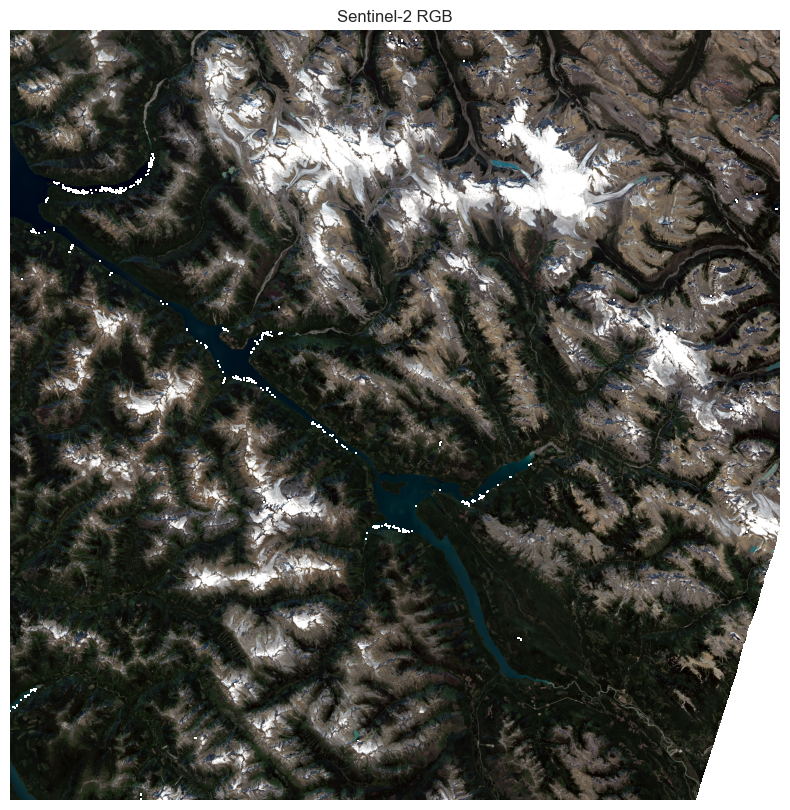

In [19]:
# Normalisation avec ajustement de brightness et gamma
def norm(band, brightness=1.2, gamma=1.6):
    p2, p98 = np.nanpercentile(band, (2, 98))
    normalized = np.clip((band - p2) / (p98 - p2), 0, 1)
    
    # Appliquer brightness
    normalized = normalized * brightness
    normalized = np.clip(normalized, 0, 1)
    
    # Appliquer gamma correction
    normalized = np.power(normalized, 1/gamma)
    
    return normalized

# Créer composition RGB avec ajustements
rgb = np.dstack([
    norm(red_masked, brightness=1.2, gamma=1.6),
    norm(green_masked, brightness=1.2, gamma=1.6),
    norm(blue_masked, brightness=1.2, gamma=1.6)
])

plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('Sentinel-2 RGB')
plt.axis('off')
plt.show()

## 6. Distribution des bandes

Histogramme lissé montrant la répartition des valeurs de réflectance pour chacune des bandes.

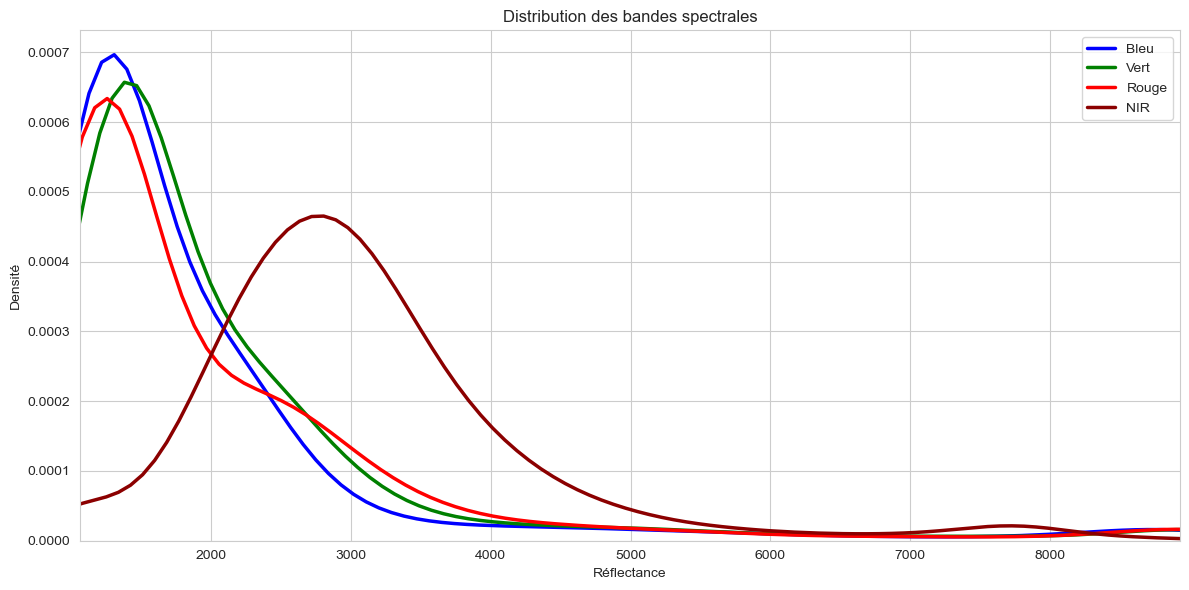

In [20]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Filtrer les NaN et sous-échantillonner
sample_size = 50000
blue_valid = blue_masked[~np.isnan(blue_masked)]
green_valid = green_masked[~np.isnan(green_masked)]
red_valid = red_masked[~np.isnan(red_masked)]
nir_valid = nir_masked[~np.isnan(nir_masked)]

blue_sample = np.random.choice(blue_valid, size=min(sample_size, blue_valid.size), replace=False)
green_sample = np.random.choice(green_valid, size=min(sample_size, green_valid.size), replace=False)
red_sample = np.random.choice(red_valid, size=min(sample_size, red_valid.size), replace=False)
nir_sample = np.random.choice(nir_valid, size=min(sample_size, nir_valid.size), replace=False)

sns.kdeplot(blue_sample, color='blue', linewidth=2.5, bw_adjust=2, label='Bleu')
sns.kdeplot(green_sample, color='green', linewidth=2.5, bw_adjust=2, label='Vert')
sns.kdeplot(red_sample, color='red', linewidth=2.5, bw_adjust=2, label='Rouge')
sns.kdeplot(nir_sample, color='darkred', linewidth=2.5, bw_adjust=2, label='NIR')

plt.xlim(np.percentile(np.concatenate([blue_sample, green_sample, red_sample, nir_sample]), [1, 99]))
plt.title('Distribution des bandes spectrales')
plt.xlabel('Réflectance')
plt.ylabel('Densité')
plt.legend()
plt.tight_layout()
plt.show()